# March Data Crunch Madness #

**Goal**

   Use Machine Learning and Statistics to predict winners of NCAA tournament games based on season performance
    
**Method**

-Performance Stats
    
   The dataset was assembled using stats from the regular season performance.  First we calculated the per game average for all available stats and created a ratio between team 1's yearly average and team 2's yearly average.  This did not prove to be predictive due to the variety in performance over the season.  For example a team might score 120 points when playing the Maine Black Bears and score 40 when playing Duke.  To account for this we took the season average for games played against teams that went on to make the tournament that season.  
    
-RPI
   
   We thought that the NCAA RPI calculation was arbitary so we decided to derive it ourselves.  This was done in excel.  We tried every combination of weights for the team's win/loss record, their opponents's combined win/loss record, and their opponent's opponent's combined winloss record.  Each of the adjusted RPI scores were the evaluated for correlation with team's depth into the tournament by round.  The new weights were 0.28, 0.47, and 0.25.  
    
-Clustering
    
   We clustered each game into one of 5 clusters using a Kmeans algorithm.  Then each cluster was evaluated to determine how often team 1 is the winner per cluster.  This number was then included as a feature.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import random
import itertools
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")
sns.set(style = 'darkgrid')
% matplotlib inline

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
games = pd.read_excel('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Upset.xlsx', sheet = 'Upset')

Scaling the seed and distance ratios (when a 16 seed plays a 1 seed it skews the data)

This is just for the violinplot, it will be scaled for real later

In [4]:
games_r = games.ix[:,13:44] #extract only the ratio columns
#games_r['upset'] = games['Upset']
games_r['team1_win'] = games['team1_win']
games_r.head(1)

,R_seed,R_lat,R_long,R_dist,R_fg2pct,R_fg3pct,R_ftpct,R_blockpct,R_oppfg2pct,R_oppfg3pct,...,R_de,R_adjde,R_rpi_rating,R_adjRPI,R_ascore,R_aagainst,R_ato,R_ashoot,R_a3shoot,team1_win
0,0.5,0.827368,1.164888,0.306771,0.950253,1.060465,1.087345,0.83242,1.058932,0.877411,...,1.023511,1.022211,1.0144,0.991728,1.053075,0.993385,0.905172,1.006757,1.08449,0


Looking for features that show a large difference in shape for wins or losses

R_seed and R_adjRPI

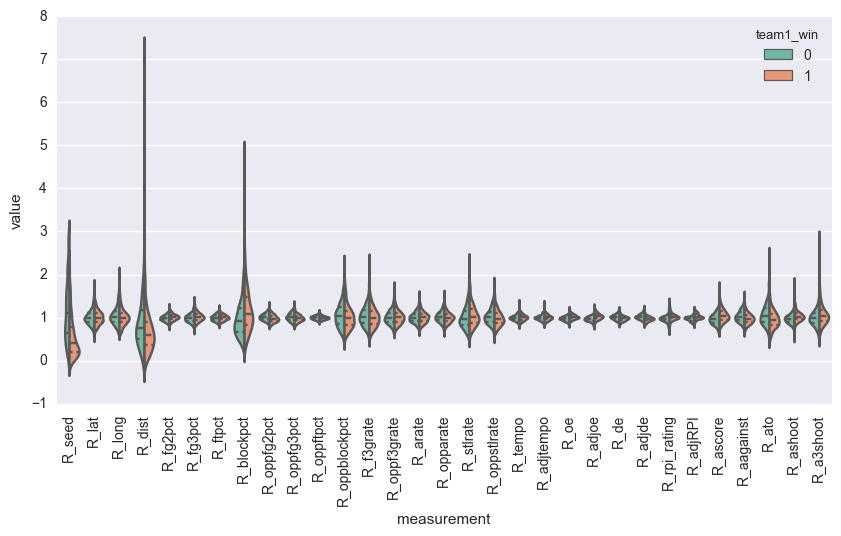

In [5]:
temp = games_r
temp['R_dist'] = np.log1p(games['R_dist'])
temp['R_seed'] = np.log1p(games['R_seed'])

m_r = pd.melt(temp, "team1_win", var_name="measurement")
fig, ax = plt.subplots(figsize=(10,5))
p = sns.violinplot(ax=ax, x="measurement", y="value", hue="team1_win", split = True, data=m_r, inner = 'quartile', palette = 'Set2');
p.set_xticklabels(rotation = 90, labels = list(temp.columns));

Extract only seasonal calculations that we have good measures for

In [6]:
feats = ['R_seed', 'R_rpi_rating', 'R_adjRPI', 'R_ascore', 'R_aagainst', 'R_ato','R_ashoot','R_a3shoot']
season = games_r[feats]
season_f = games_r[feats]
season_f['team1_win'] = games_r['team1_win']
season_f.head(1)

,R_seed,R_rpi_rating,R_adjRPI,R_ascore,R_aagainst,R_ato,R_ashoot,R_a3shoot,team1_win
0,0.405465,1.0144,0.991728,1.053075,0.993385,0.905172,1.006757,1.08449,0


Shows the relationship between the Adjusted RPI and the stock RPI

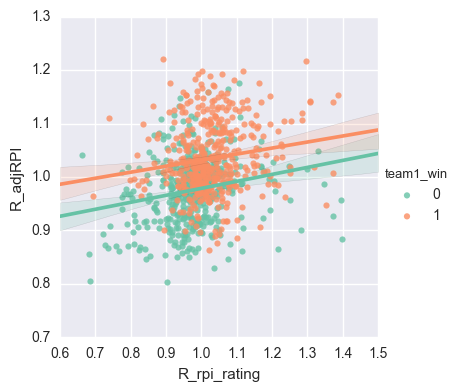

In [7]:
sns.lmplot(x = 'R_rpi_rating', y = 'R_adjRPI',  hue='team1_win', size = 4, data = season_f, palette = 'Set2');

In [8]:
X = season
y = season_f['team1_win']
X.head()

,R_seed,R_rpi_rating,R_adjRPI,R_ascore,R_aagainst,R_ato,R_ashoot,R_a3shoot
0,0.405465,1.014400,0.991728,1.053075,0.993385,0.905172,1.006757,1.084490
1,0.060625,1.372294,1.140164,1.412429,1.170699,0.875000,0.946802,0.894637
2,0.887303,1.124272,1.001606,0.944023,1.048039,1.160714,1.094110,0.867539
3,1.791759,0.916667,1.008218,0.834399,0.980126,0.993377,0.961527,0.960213
4,1.446919,0.808442,0.928417,0.790785,1.056430,1.277372,0.845056,1.101421


Split Train and Test data 67/33

Train a scaler based on the Training data and apply it to the test and training set to improve model performance

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler() 
scaler.fit(X_train)

scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

X_test = scaler.transform(X_test)  

In [10]:
X.columns

Index(['R_seed', 'R_rpi_rating', 'R_adjRPI', 'R_ascore', 'R_aagainst', 'R_ato',
       'R_ashoot', 'R_a3shoot'],
      dtype='object')

Train Kmeans model

Fit test set and use that to evaluate win percentage per cluster

In [11]:
kmeans = KMeans(n_clusters = 3, random_state = 0,init='k-means++',max_iter = 100)

kmeans_pred = kmeans.fit(X_train)

clust = kmeans.predict(X)
X['Clust'] = clust
list(set(clust))

[1, 2]

cols = ['R_seed',
 'R_rpi_rating',
 'R_adjRPI',
 'R_ascore',
 'R_aagainst',
 'R_ato',
 'R_ashoot',
 'R_a3shoot',
 'team1_win',
 'Clust']
targets = up_f[cols]
targets.head(1)

Split Train and Test data 67/33

Train a scaler based on the Training data and apply it to the test and training set to improve model performance

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler() 
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [13]:
x1 = X
x1['result'] = season_f['team1_win']

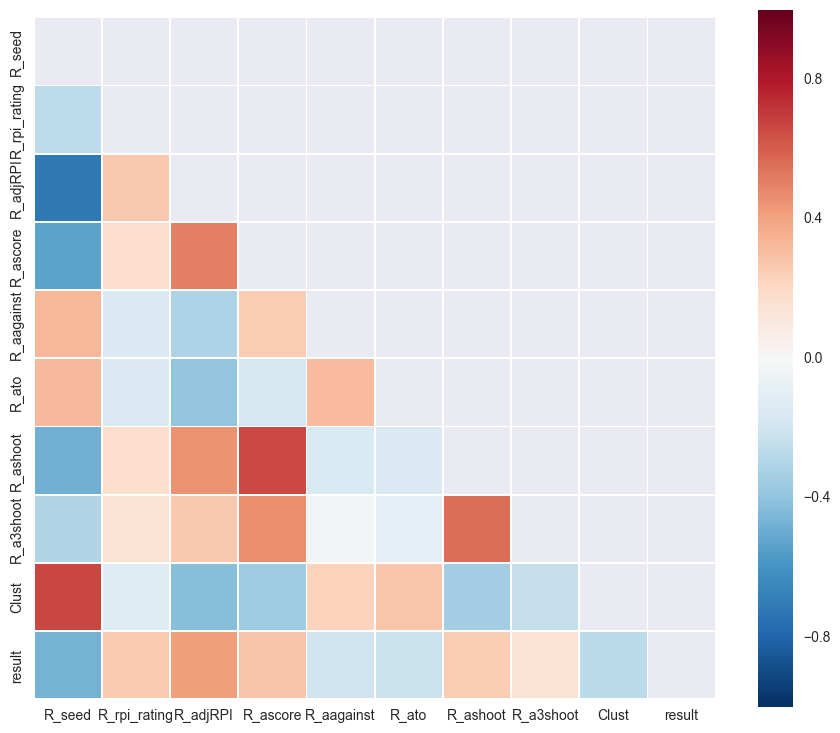

In [14]:
corr = x1.corr()
fg, ax = plt.subplots(figsize = (11,9))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask = mask, linewidths = .5, square = True);

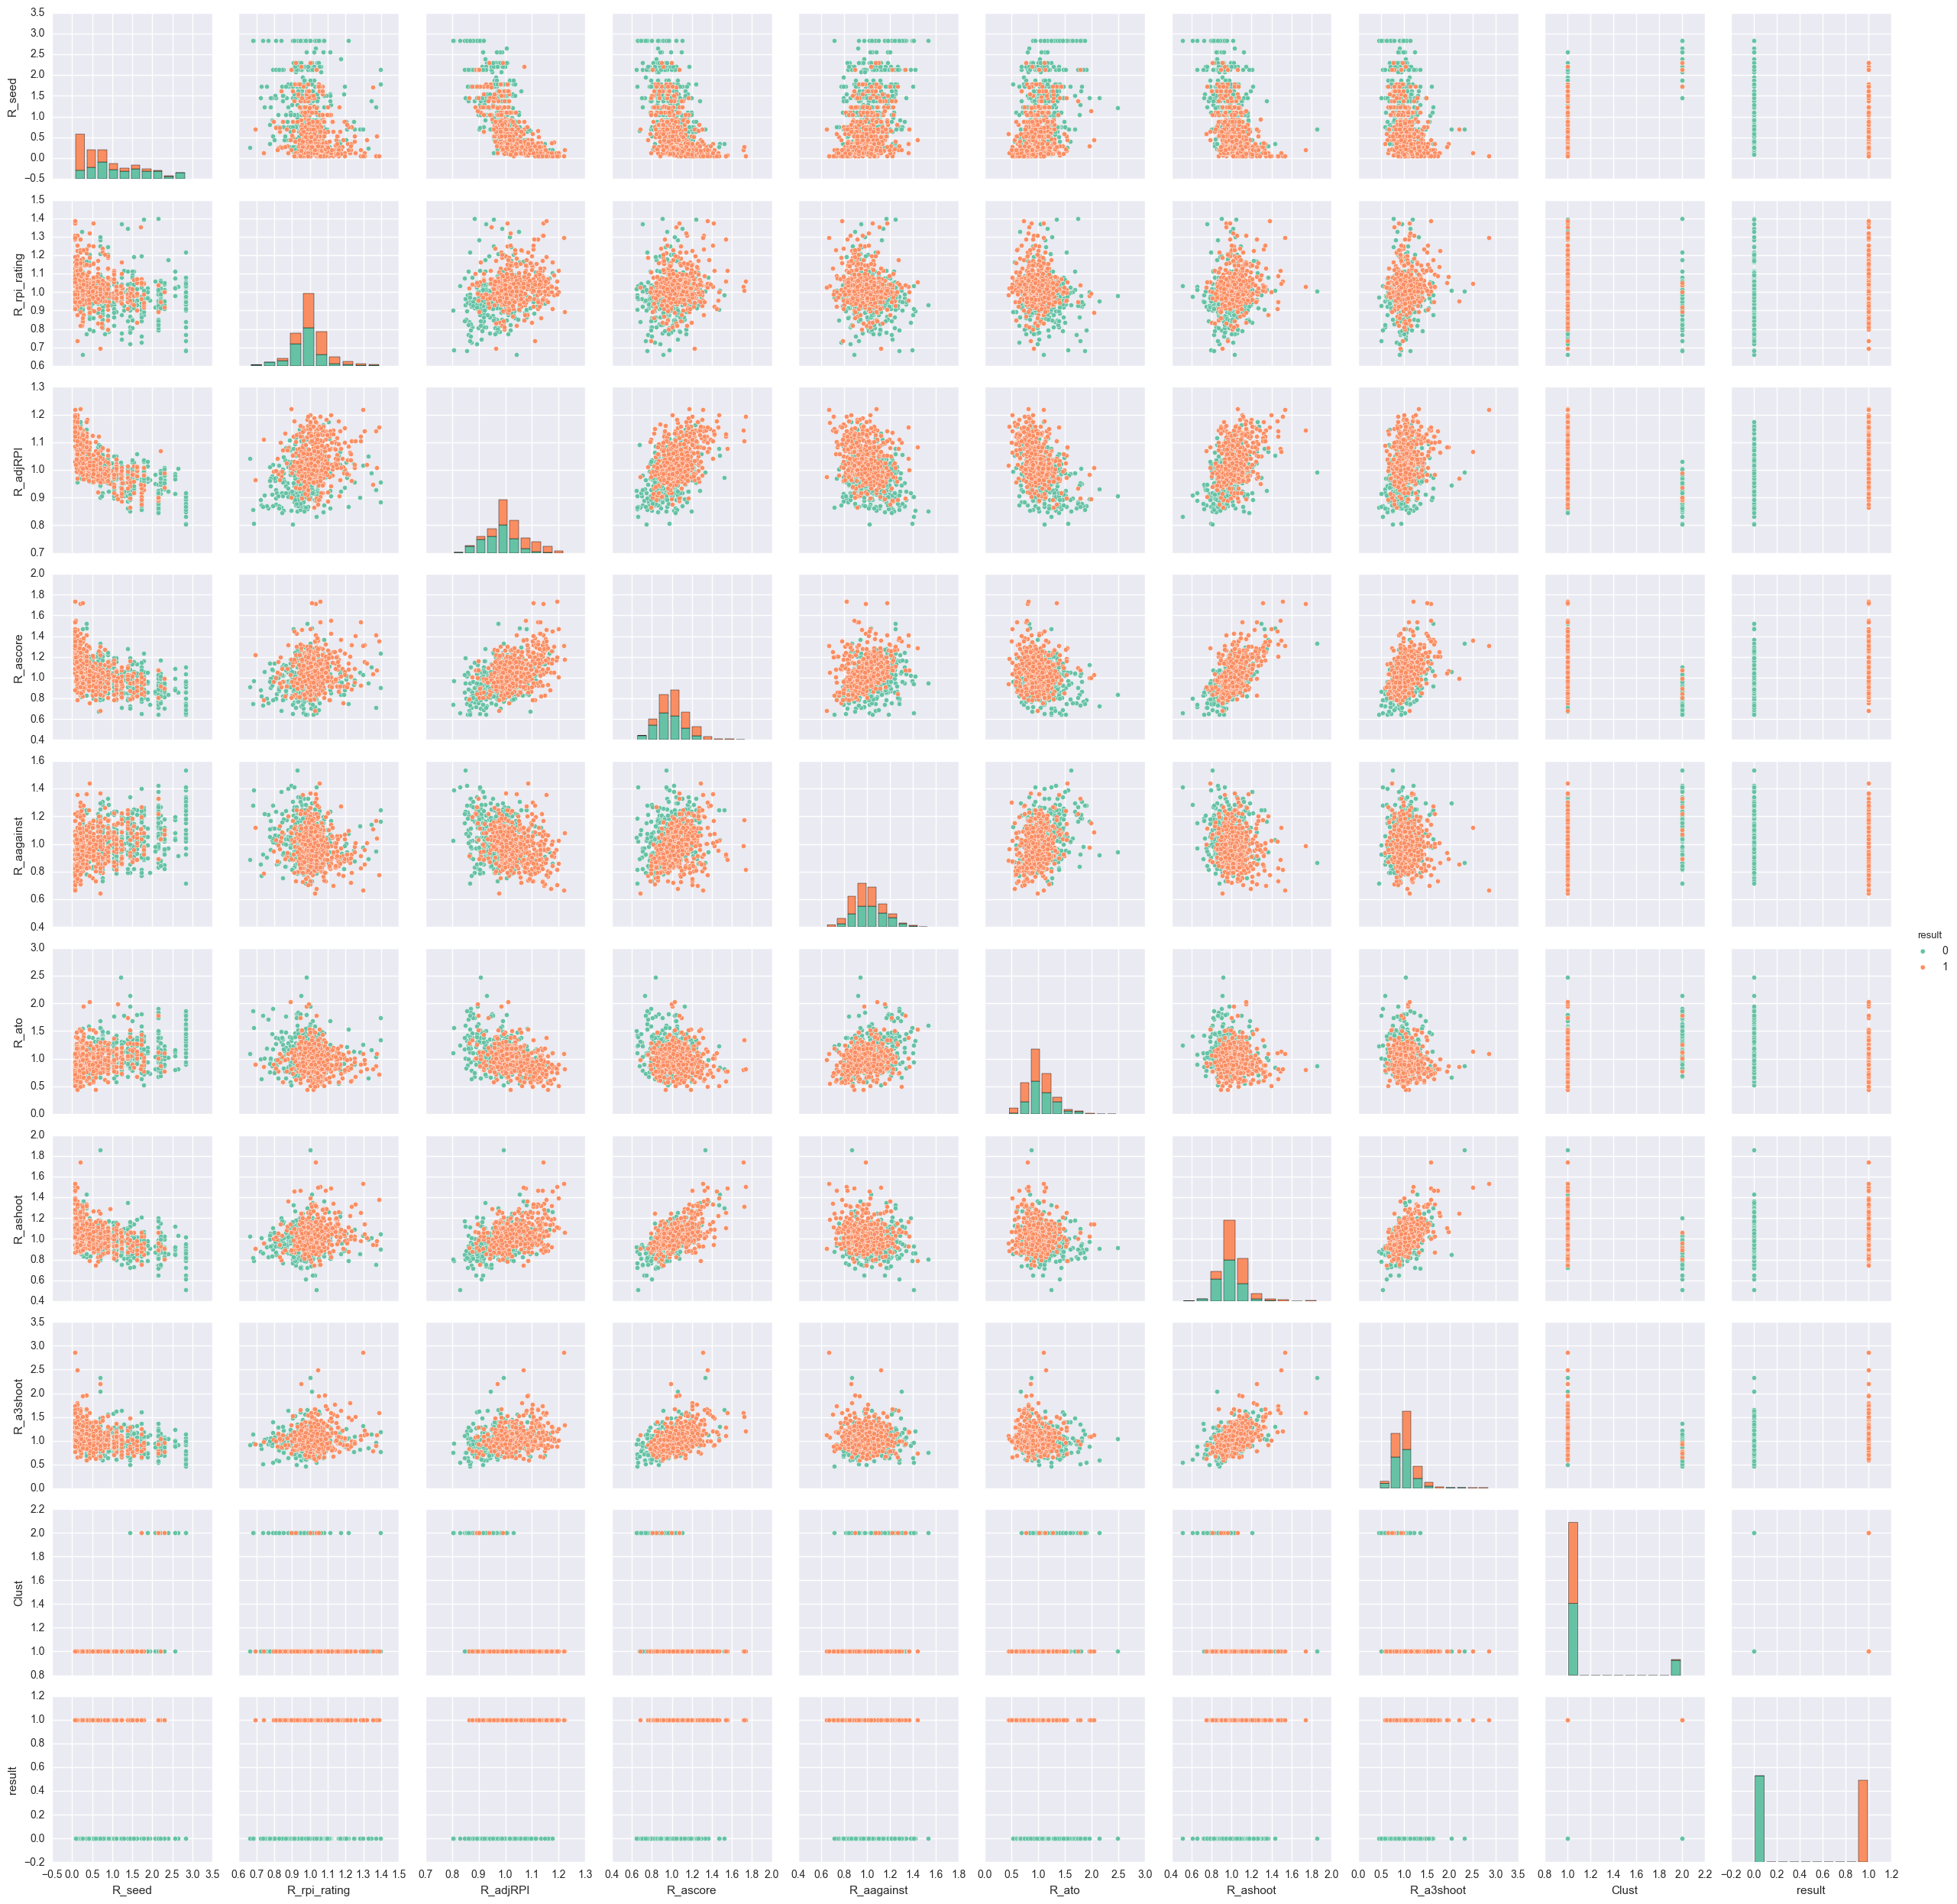

In [15]:
sns.pairplot(x1, hue="result", palette = 'Set2');

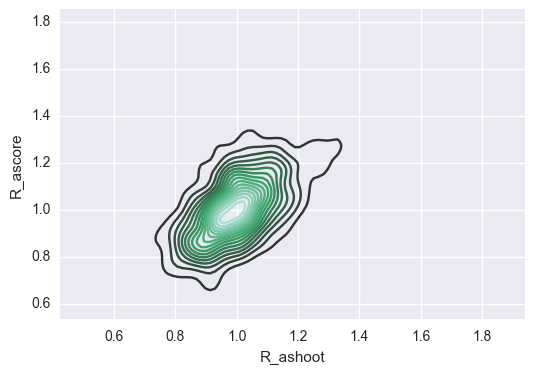

In [16]:
sns.kdeplot(x1["R_ashoot"], x1["R_ascore"],n_levels = 20);

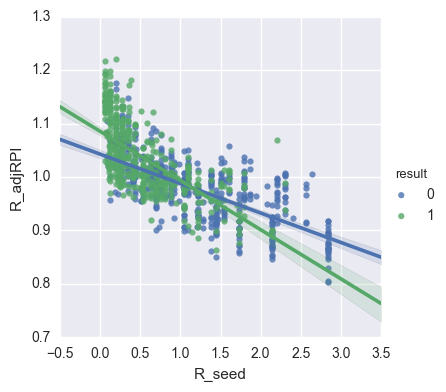

In [17]:
sns.lmplot(x = 'R_seed', y = 'R_adjRPI',  hue='result', size = 4, data = x1);

Capture model stats

In [18]:
m_eval = pd.DataFrame(columns = ['method','trainscore','testscore','truepos','trueneg'])

In [19]:
def addeval(method, train, test, tpos, tneg):
    global m_eval
    d = pd.DataFrame([[method, train, test, tpos, tneg]],columns = ['method','trainscore','testscore','truepos','trueneg'])
    m_eval = m_eval.append(d)

**All Confusion Matrices have predicted values [0,1] on the vertical axis, and true values [0,1] on the horizonal axis**

# SVC

In [20]:
###SVC
svc = SVC(kernel = 'rbf',C=1, gamma=.1, probability = True)
svc_pred = svc.fit(X_train, y_train).predict(X_test)
svc.score(X_train,y_train), svc.score(X_test, y_test),svc.score(X_train,y_train)-svc.score(X_test,y_test)

(0.74183006535947715, 0.72516556291390732, 0.016664502445569829)

In [21]:
mtrx = confusion_matrix(y_test,svc_pred)
mtrx

array([[115,  25],
       [ 58, 104]])

In [22]:
addeval('SVC',svc.score(X_train,y_train), svc.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Neural Net

In [23]:
###Neural Net
nn = MLPClassifier(solver='adam', activation = 'logistic',hidden_layer_sizes=(20, 15), random_state=1)

nn_pred = nn.fit(X_train,y_train).predict(X_test)
nn.score(X_train,y_train), nn.score(X_test,y_test), nn.score(X_train,y_train)-nn.score(X_test,y_test)

(0.71241830065359479, 0.70860927152317876, 0.0038090291304160306)

In [24]:
mtrx = confusion_matrix(y_test,nn_pred)
mtrx

array([[117,  23],
       [ 65,  97]])

In [25]:
addeval('Neural Net',nn.score(X_train,y_train), nn.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Extra Trees

In [26]:
###ETC
etc = ExtraTreesClassifier()
etc_pred = etc.fit(X_train,y_train).predict(X_test)
etc.score(X_train,y_train), etc.score(X_test,y_test), etc.score(X_train,y_train)-etc.score(X_test,y_test)

(1.0, 0.67880794701986757, 0.32119205298013243)

In [27]:
mtrx = confusion_matrix(y_test,etc_pred)
mtrx

array([[117,  23],
       [ 74,  88]])

In [28]:
addeval('Extra Trees',etc.score(X_train,y_train), etc.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Adaptive Boosting

In [29]:
###Adaptive Boosting
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=600,learning_rate=1)

ada_pred = ada.fit(X_train,y_train).predict(X_test)
ada.score(X_train,y_train), ada.score(X_test,y_test), ada.score(X_train,y_train)-ada.score(X_test,y_test)

(1.0, 0.66225165562913912, 0.33774834437086088)

In [30]:
mtrx = confusion_matrix(y_test,ada_pred)
mtrx

array([[103,  37],
       [ 65,  97]])

In [31]:
addeval('Ada',ada.score(X_train,y_train), ada.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# KNN

In [32]:
knn = KNeighborsClassifier(n_neighbors = 14, algorithm = 'auto', weights = 'uniform')
knn_pred = knn.fit(X_train, y_train).predict(X_test)
knn.score(X_train,y_train), knn.score(X_test,y_test), knn.score(X_train,y_train)-knn.score(X_test,y_test)

(0.72058823529411764, 0.66225165562913912, 0.058336579664978516)

In [33]:
mtrx = confusion_matrix(y_test,knn_pred)
mtrx

array([[111,  29],
       [ 73,  89]])

In [34]:
addeval('KNN',knn.score(X_train,y_train), knn.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Gaussian NB 

In [35]:
gauss = GaussianNB()
gauss_pred = gauss.fit(X_train, y_train).predict(X_test)
gauss.score(X_train,y_train), gauss.score(X_test,y_test), gauss.score(X_train,y_train)-gauss.score(X_test,y_test)

(0.67810457516339873, 0.7516556291390728, -0.073551053975674074)

In [36]:
mtrx = confusion_matrix(y_test,gauss_pred)
mtrx

array([[100,  40],
       [ 35, 127]])

In [37]:
addeval('GaussNB',gauss.score(X_train,y_train), gauss.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# SGD

In [38]:
sgd = SGDClassifier(loss='hinge', eta0=1, learning_rate='constant', penalty=None)
sgd_pred = sgd.fit(X_train, y_train).predict(X_test)
sgd.score(X_train,y_train), sgd.score(X_test,y_test), sgd.score(X_train,y_train)-sgd.score(X_test,y_test)

(0.70915032679738566, 0.70529801324503316, 0.0038523135523524932)

In [39]:
mtrx = confusion_matrix(y_test,sgd_pred)
mtrx

array([[114,  26],
       [ 63,  99]])

In [40]:
addeval('SGD',sgd.score(X_train,y_train), sgd.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Perceptron

In [41]:
#Perceptron and SGDClassifier share the same underlying implementation. In fact, Perceptron() is 
#equivalent to SGDClassifier(loss=”perceptron”, eta0=1, learning_rate=”constant”, penalty=None).
perc = Perceptron(alpha = 0.001, penalty = None,fit_intercept = True)
perc_pred = perc.fit(X_train, y_train).predict(X_test)
perc.score(X_train,y_train), perc.score(X_test,y_test), perc.score(X_train,y_train)-perc.score(X_test,y_test)

(0.66503267973856206, 0.72847682119205293, -0.063444141453490865)

In [42]:
mtrx = confusion_matrix(y_test,perc_pred)
mtrx

array([[ 94,  46],
       [ 36, 126]])

In [43]:
addeval('Perceptron',sgd.score(X_train,y_train), sgd.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

In [44]:
m_eval

,method,trainscore,testscore,truepos,trueneg
0,SVC,0.741830,0.725166,104.0,115.0
0,Neural Net,0.712418,0.708609,97.0,117.0
0,Extra Trees,1.000000,0.678808,88.0,117.0
0,Ada,1.000000,0.662252,97.0,103.0
0,KNN,0.720588,0.662252,89.0,111.0
0,GaussNB,0.678105,0.751656,127.0,100.0
0,SGD,0.709150,0.705298,99.0,114.0
0,Perceptron,0.709150,0.705298,126.0,94.0


In [45]:
mm1_eval = pd.melt(m_eval[['method','truepos','trueneg']], "method", var_name="measurement")
mm2_eval = pd.melt(m_eval[['method','trainscore','testscore']], "method", var_name="measurement")

This chart shows the True Positive and True Negative rate for each method

SVC and Neural Net show the identical TP and TN 
GaussNB has the highest overall test set score and over all correct predictions.

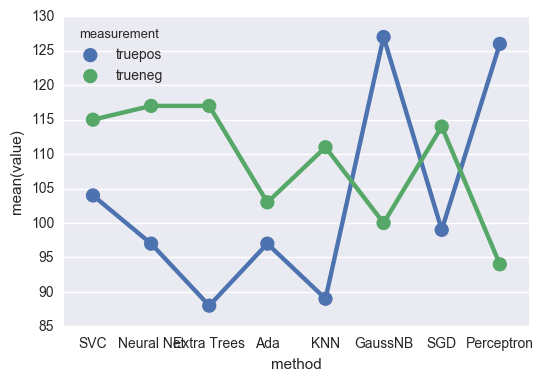

In [46]:
sns.pointplot(x="method", y="value", hue="measurement", data=mm1_eval);

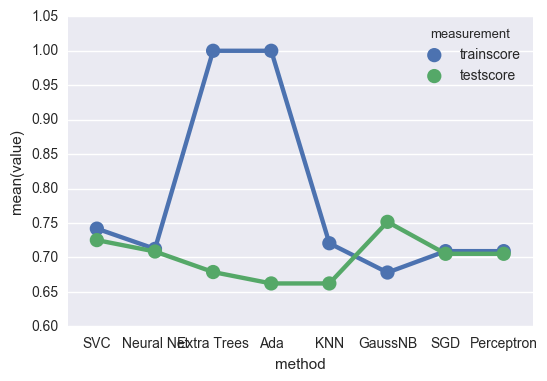

In [47]:
sns.pointplot(x="method", y="value", hue="measurement", data=mm2_eval);

# Calculate LogLoss#
Using a combination of SVC to predict **losses** and Gaussian Naive Bayes to predict **wins**

In [48]:
X = X.drop('result',axis = 1)
X.head(1)

,R_seed,R_rpi_rating,R_adjRPI,R_ascore,R_aagainst,R_ato,R_ashoot,R_a3shoot,Clust
0,0.405465,1.0144,0.991728,1.053075,0.993385,0.905172,1.006757,1.08449,1


In [49]:
svc_target = pd.DataFrame(svc.predict_proba(X),columns = ['predicted','inverse'])
gauss_target = pd.DataFrame(gauss.predict_proba(X),columns = ['predicted','inverse'])
nn_target = pd.DataFrame(nn.predict_proba(X),columns = ['predicted','inverse'])

In [50]:
low = 0.1
high = 0.9

X['svc_pred'] = minmax_scale(svc_target['inverse'],feature_range=(low,high))
X['gauss_pred'] = minmax_scale(gauss_target['inverse'], feature_range=(low,high))
X['nn_pred'] = minmax_scale(nn_target['inverse'], feature_range=(low,high))

In [51]:
X['result'] = y

Calculate the Log Loss score

In [52]:
print('SVC Log Loss Score: ' + str(log_loss(X['result'],X['svc_pred'])))
print('Gauss Log Loss Score: ' + str(log_loss(X['result'],X['gauss_pred'])))
print('Neural Net Log Loss Score: ' + str(log_loss(X['result'],X['nn_pred'])))

SVC Log Loss Score: 0.614040631978
Gauss Log Loss Score: 0.692716094431
Neural Net Log Loss Score: 0.564179212906


**Calculate composite predictions**

   If the Gaussian model predicts a win with more confidence than the SVC model predicts a loss, return a win.
   If the SVC model predicts a loss with more confidence than the Gaussian model predicts a win, return a loss.

In [53]:
x1 = X[['svc_pred','gauss_pred','result']]
x1['svc_strngth'] = 0.5 - x1['svc_pred']
x1['gauss_strngth'] = x1['gauss_pred']-0.5

In [54]:
def calcrow(df):
    if (df['gauss_strngth']>0 and df['gauss_strngth'] > df['svc_strngth']):
        return "Gauss"
    else:
        return "SVC"
        
def scorerow(df):
    if df['cmpst'] == "Gauss":
        return df['gauss_pred']
    else:
        return df['svc_pred']

In [55]:
x1['cmpst'] = x1.apply(calcrow,axis = 1)
x1['cmpst_pred'] = x1.apply(scorerow,axis =1)

In [56]:
X['cmpst_pred'] = x1['cmpst_pred']

print('SVC Log Loss Score: ' + str(log_loss(X['result'],X['svc_pred'])))
print('Gauss Log Loss Score: ' + str(log_loss(X['result'],X['gauss_pred'])))
print('Neural Net Log Loss Score: ' + str(log_loss(X['result'],X['nn_pred'])))
print('Composite Log Loss Score: ' + str(log_loss(X['result'],X['cmpst_pred'])))

SVC Log Loss Score: 0.614040631978
Gauss Log Loss Score: 0.692716094431
Neural Net Log Loss Score: 0.564179212906
Composite Log Loss Score: 0.624000281038


Composite Predictor did **not** prove to be better than the Neural Net by itself

**Predict All Possible Matchups**

In [57]:
pred = pd.read_excel('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Frame.xlsx', sheet = 'Sheet1')

In [58]:
years = [2013,2014,2015,2016]

In [59]:
pred = pred[(pred['Year'].isin(years))]
pred1 = pred.ix[:,4:12]
list(pred1.columns)

['R_seed',
 'R_rpi_rating',
 'R_adjRPI',
 'R_ascore',
 'R_aagainst',
 'R_ato',
 'R_shoot',
 'R_3shoot']

In [60]:
clust = kmeans.predict(pred1)
pred1['Clust'] = clust
set(clust)

{0, 1, 2}

In [61]:
#pred1 = pd.merge(pred1,c_score, how = 'left', left_on = 'Clust',right_on = 'Clust')
#pred1 = pred1.drop('Clust',axis = 1)

In [62]:
p = pd.DataFrame(nn.predict_proba(pred1),columns = ['predicted','inverse'])
q = pd.DataFrame(svc.predict_proba(pred1),columns = ['predicted','inverse'])

In [63]:
len(pred1),len(p)

(9112, 9112)

In [64]:
pred['nnpred'] = p['inverse']
pred['svcpred'] = q['inverse']
pred['scale'] = minmax_scale(pred['nnpred'], feature_range=(low,high),axis = 0, copy = True)
pred.head()

,Year,Team1,Team2,id,R_seed,R_rpi_rating,R_adjRPI,R_ascore,R_aagainst,R_ato,...,1rpi2,1adjrpi2,1ascore2,1aagainst2,1ato2,1ashoot2,1a3shoot3,nnpred,svcpred,scale
0,2013,1231,1274,2013_1231_1274,0.500000,0.991455,0.995917,1.009688,1.057272,1.144715,...,0.635635,0.639878,73.818182,67.090909,11.181818,0.462054,0.388611,0.347316,0.334091,0.471002
1,2013,1231,1266,2013_1231_1266,0.333333,1.041433,1.045860,1.175890,1.072248,0.885106,...,0.605131,0.609322,63.384615,66.153846,14.461538,0.449383,0.309510,0.399363,0.410744,0.557642
2,2013,1231,1393,2013_1231_1393,0.250000,1.018958,1.020402,1.216540,1.125926,0.989691,...,0.618478,0.624524,61.266667,63.000000,12.933333,0.411019,0.318593,0.398452,0.422108,0.556126
3,2013,1231,1424,2013_1231_1424,0.200000,1.046843,1.049933,1.063677,1.028019,0.909645,...,0.602004,0.606958,70.071429,69.000000,14.071429,0.419632,0.334719,0.419961,0.434301,0.591931
4,2013,1231,1301,2013_1231_1301,0.125000,1.056074,1.061715,0.990476,0.875720,1.003922,...,0.596742,0.600222,75.250000,81.000000,12.750000,0.492305,0.401633,0.441862,0.433585,0.628390


In [66]:
pred[['id','nnpred']].to_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Predictions\\Kagglesub6.csv')